In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os

while 'jupyter' in os.getcwd():
    os.chdir("../")

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/msat/projects/white-box-nn


In [19]:
import torch
from torch import einsum, nn
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
import torch.nn.functional as F

import pandas as pd
import seaborn as sn
import numpy as np
import math
import random
import cv2
import matplotlib.pyplot as plt

from collections import OrderedDict

import kornia
from kornia.geometry.transform import affine, translate, rotate
from kornia.enhance import adjust_brightness, adjust_contrast, adjust_hue, adjust_saturation, adjust_gamma

from art.attacks.evasion import FastGradientMethod, AutoAttack, AutoProjectedGradientDescent, SquareAttack, BoundaryAttack
from art.estimators.classification import PyTorchClassifier

from lib.datamodules import MNISTDataModule
from lib.helpers import hh, normalize_weight_, normalize_weight
from lib.lightning_modules.cls_module import ClsModule

from lib.modules.augment import Noise
from lib.modules.sf_layers import AffineLayer, TwoStepFunction, ConvLayer
from lib.modules.sf_samplers import SFSampler, AffineSampler, RotationSampler

BATCH_SIZE = 200

# LABELS = None
# LABELS = [0, 1, 2, 3, 4, 5, 6, 7]
LABELS = [3, 5]
N_CLASSES = len(LABELS) if LABELS else 10

prefix = "mnist"
IMG_SHAPE = (1, 28, 28)
EPS = 0.3
STEP_SIZE = 0.1

VERSION = 0
MODEL_SAVE_PATH = f"models/{prefix}/wbnn_state_dict_{VERSION}.pt"
DIM_INPUT = torch.prod(torch.tensor(IMG_SHAPE))
LOGS_DIR = f"logs/{prefix}_sf_model/"

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
device

'cpu'

In [20]:
datamodule = MNISTDataModule(batch_size=BATCH_SIZE, labels=LABELS, shape=IMG_SHAPE[1:])

datamodule.prepare_data()
datamodule.setup()

In [21]:
x_test_all, y_test_all = next(iter(datamodule.test_dataloader(len(datamodule.mnist_test))))
x_test, y_test = x_test_all[:48], y_test_all[:48]
x_test_small, y_test_small = x_test_all[32:48], y_test_all[32:48]

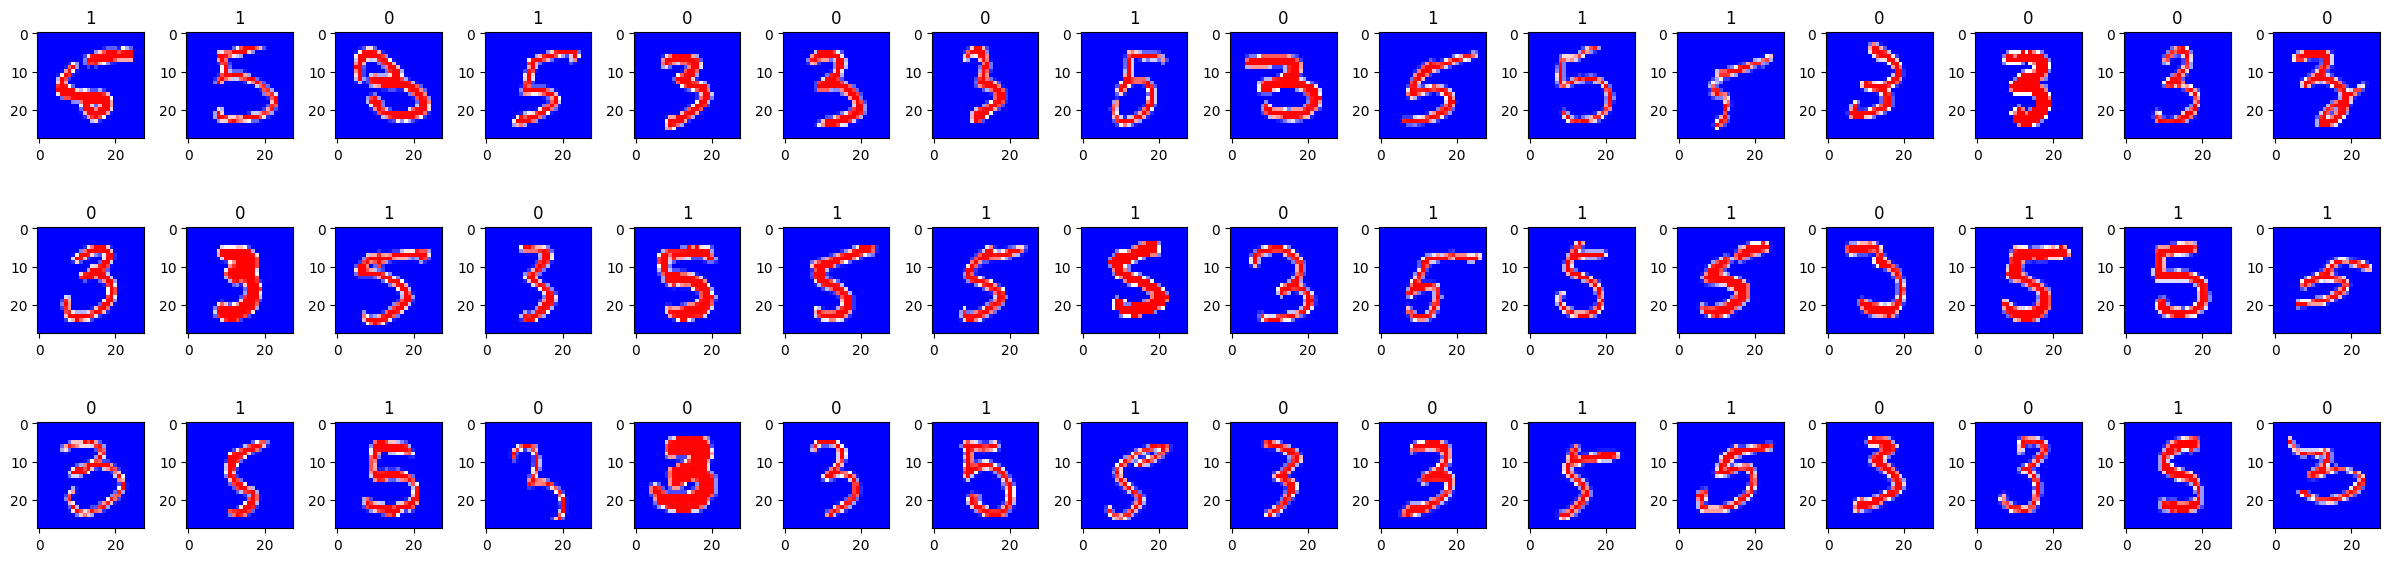

In [22]:
hh.plot_example(x_test, y_test)

# Train

In [264]:
seed = 314
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

augment = nn.Sequential(
    Noise(mean=0.05, scale=0.25, clip=True, p=0.7),
)

latent_dim = 2

pixel_layer = TwoStepFunction(10)

conv_layer = ConvLayer(
    sampler=RotationSampler(16),
    n_kernels=2,
    kernel_size=5,
    act=nn.ReLU(),
    # add_bias=True,
    # rescale=False,
)

affine_layer = AffineLayer(
    sampler=AffineSampler(32, dim_pose_group=latent_dim),
    inp_shape=IMG_SHAPE,
    feature_shape=(1, 18, 18),
    out_dim=latent_dim,
    # act=nn.ReLU(),
    # add_bias=True,
    # rescale=False,
)

head = nn.Linear(
    latent_dim,
    N_CLASSES,
    bias=False,
    # bias=True,
)
# with torch.no_grad():
#     w = head.weight
#     nn.init.eye_(w)

backbone = nn.Sequential(OrderedDict([
    ('pixel', pixel_layer),
    ('conv', conv_layer),
    ('affine', affine_layer),
    # ('head', head),
]))

model = ClsModule(
    learning_rate=3e-3, # BEST
    # weight_decay=3e-7,# 0.00001,
    weight_decay=3e-6,# BEST?
    # weight_decay=0.0,
    noise_eps=EPS,
    adv_prob=0.,
    # adv_prob=1.0,
    val_adv_prob=1.0,
    n_classes=N_CLASSES,
    augment=augment,
    backbone=backbone,
)

bb = model.backbone
model(torch.zeros_like(x_test))  # sanity check + potential lazy initialization
pass

In [265]:
batch_size = BATCH_SIZE
# batch_size = 1
datamodule = MNISTDataModule(batch_size=batch_size, labels=LABELS, shape=IMG_SHAPE[1:])

trainer = Trainer(
    accelerator="auto",
    # precision=16,
    # devices=1 if torch.cuda.is_available() else None,
    devices="auto",
    # max_epochs=2,
    # max_epochs=3,
    # max_epochs=5,
    max_epochs=10,
    # max_epochs=15,
    # max_epochs=20,
    # max_epochs=30,
    callbacks=[TQDMProgressBar(refresh_rate=2)],
    logger=CSVLogger(save_dir=LOGS_DIR, version=VERSION),
)

trainer.fit(
    model=model,
    datamodule=datamodule,
    # ckpt_path=f"{LOGS_DIR}lightning_logs/version_{version}/checkpoints/epoch=9-step=1130.ckpt",
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/mnist_sf_model/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory logs/mnist_sf_model/lightning_logs/version_0/checkpoints exists and is not empty.

  | Name              | Type                       | Params
-----------------------------------------------------------------
0 | loss              | CrossEntropyLoss           | 0     
1 | augment           | Sequential                 | 0     
2 | backbone          | Sequential                 | 1.1 K 
3 | train_accuracy    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


# Inspect model

In [266]:
# Test on full test (PGD attack)
model.to(device)
model.eval()
trainer.test(model, datamodule)
model.eval()
model.training

/usr/local/Caskroom/miniconda/base/envs/wbnn/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_adv_acc          0.9137749671936035
      test_adv_loss         0.21320876479148865
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


False

tensor(0.9138)

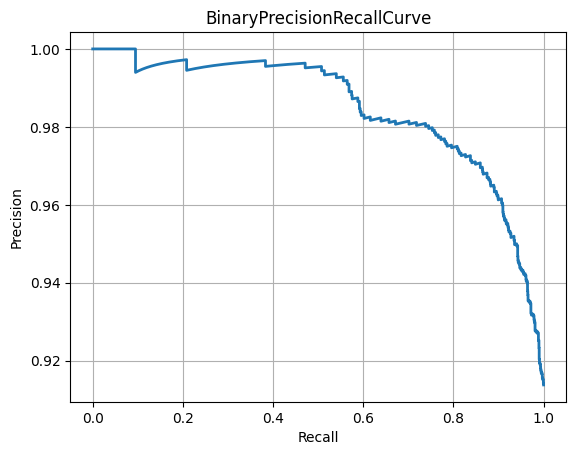

In [267]:
p, r, t = model.reliability_curve.compute()
model.reliability_curve.plot()
p.min()

,train_acc,train_loss,val_adv_acc,val_adv_loss
epoch,,,,
6,1.000,0.018390,NaN,NaN
6,0.995,0.031778,NaN,NaN
6,NaN,NaN,0.903260,0.230032
7,0.985,0.047683,NaN,NaN
7,NaN,NaN,0.906414,0.227296
8,0.990,0.032185,NaN,NaN
8,NaN,NaN,0.905363,0.231739
9,0.970,0.054590,NaN,NaN
9,NaN,NaN,0.917981,0.211693


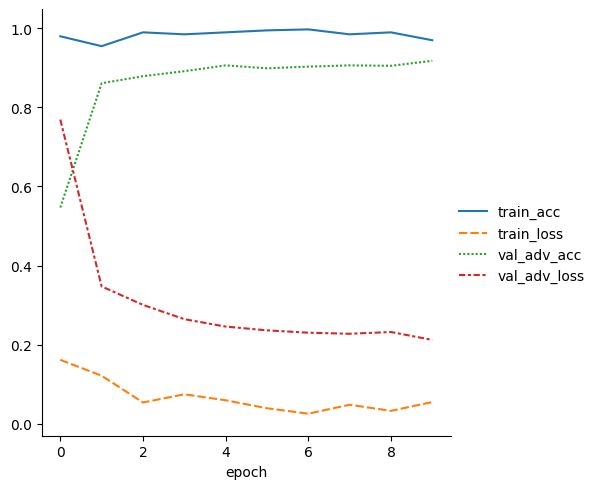

In [268]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
metrics = metrics[["train_acc", "train_loss", "val_adv_acc", "val_adv_loss", "epoch"]]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").tail(10))
met = metrics[metrics.index >= 0] # first few epochs might be an outliers
sn.relplot(data=met, kind="line")

In [269]:
def visualize_processing_steps(bb, x):
    x0 = bb.pixel(x)
    x1 = bb.conv(x0)
    x2, f = bb.affine(x1, with_features=True)
    # x3 = bb.head(x2)
    x3 = x2

    f1, f2 = torch.split(f, 1, dim=1)
    f1, f2 = f1[:, 0], f2[:, 0]
    f1, f2 = f1 + 0.1 * x1, f2 + 0.1 * x1

    y = [(round(scores[0].item(), ndigits=2), round(scores[1].item(), ndigits=2)) for scores in x3.softmax(dim=1)]
    y += ['pixel' for _ in range(len(x3))]
    y += ['conv' for _ in range(len(x3))]
    y += [round(e.item(), ndigits=2) for e in x2[:, 0]]
    y += [round(e.item(), ndigits=2) for e in x2[:, 1]]

    ret = torch.cat([x, x0, x1, f1, f2], dim=0)

    return ret, y

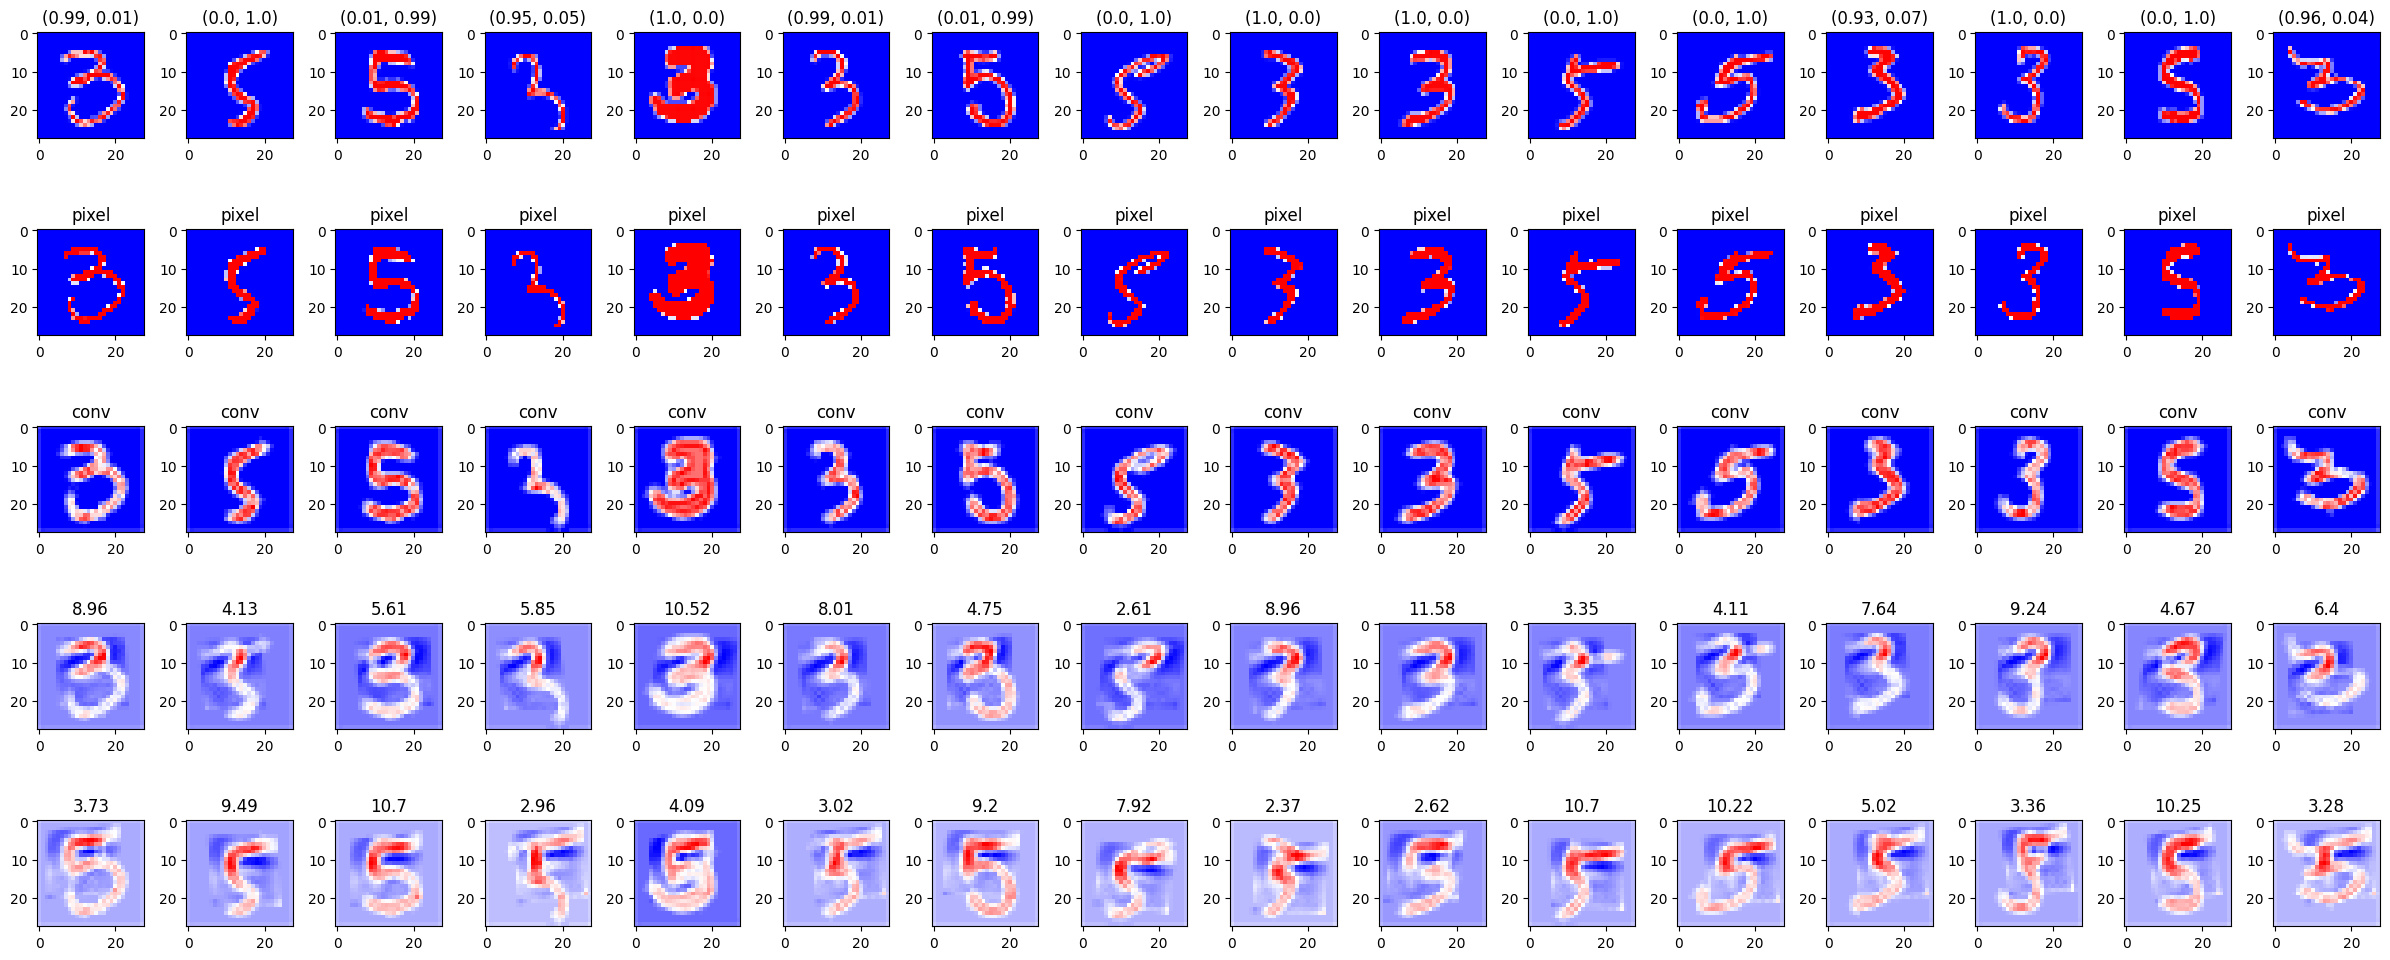

In [270]:
xx = augment(x_test_small)
layer_vis, labels = visualize_processing_steps(bb, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

Learned 2-step: TwoStepFunction(0.363, 0.564, 0.58, 0.664, scales=[0.001, 0.042, 0.256, 0.004])


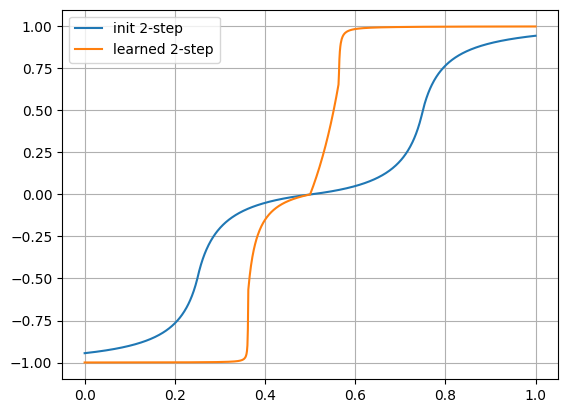

In [271]:

n_steps = 1000
thr = torch.tensor(range(n_steps + 1)) / n_steps

val_learned = bb.pixel(thr)
val_init = TwoStepFunction(10)(thr)
plt.plot(thr, val_init.detach(), label='init 2-step')
plt.plot(thr, val_learned.detach(), label='learned 2-step')
plt.legend()

print("Learned 2-step:", bb.pixel)

ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
plt.grid(True)
plt.show()

tensor(-0.2396) tensor(0.4224) 1.874935507774353


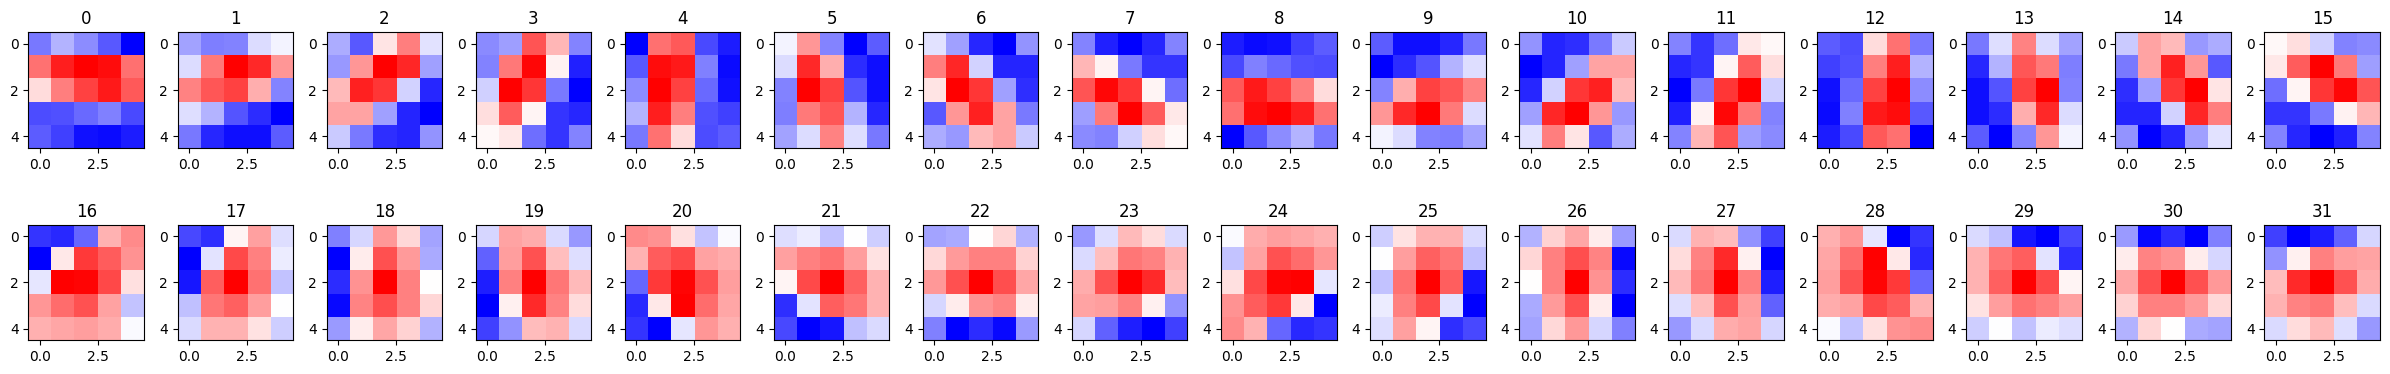

In [272]:
cc = bb.conv.get_weight().detach().flatten(0, 1)
print(cc.min(), cc.max(), bb.conv.scale.item())

hh.plot_example(cc, n_row=2, n_col=16)

-0.16387231647968292 0.2568507492542267 Parameter containing:
tensor([1.8749], requires_grad=True) Parameter containing:
tensor([[0., 0.]], requires_grad=True)


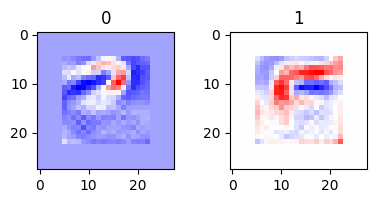

In [273]:
f = bb.affine.get_features()
print(f.min().item(), f.max().item(), bb.affine.scale, bb.affine.bias)

hh.plot_example(f, list(range(len(f))), n_col=2, n_row=1)
# hh.plot_example(f, list(range(len(f))), n_col=16, n_row=4)

tensor(-0.1855) tensor(0.2701)


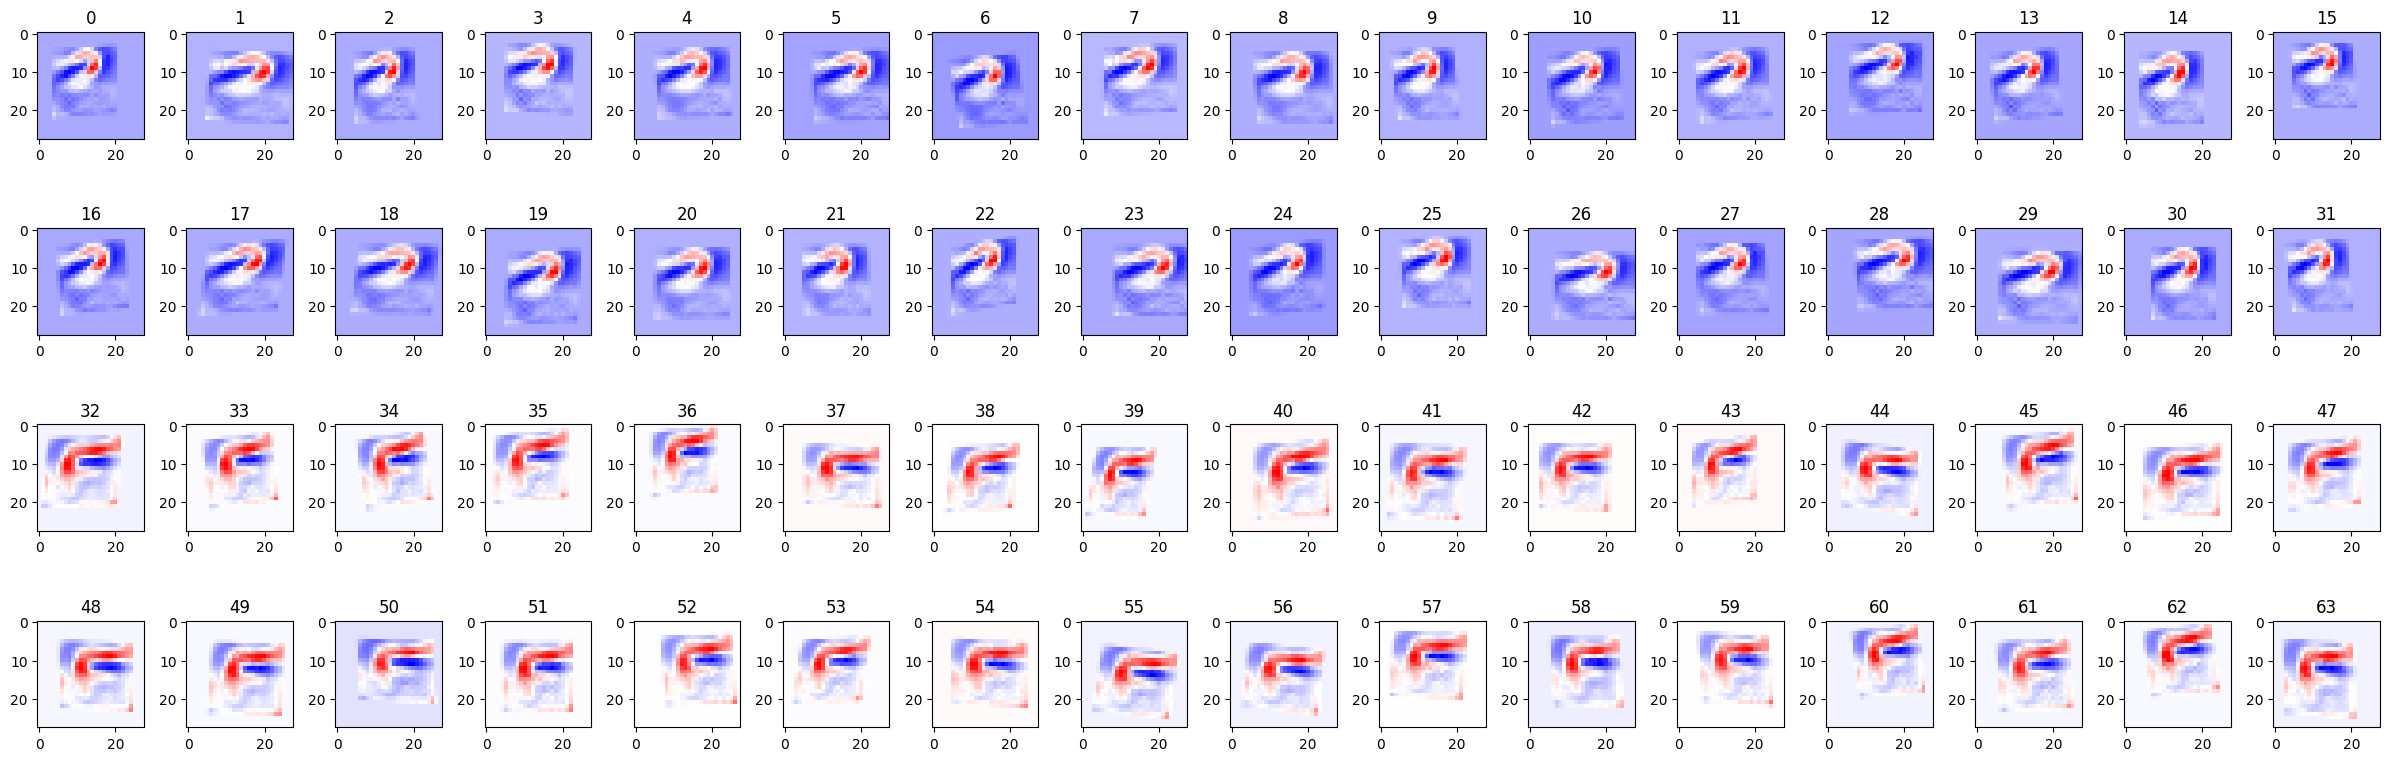

In [274]:
ff = bb.affine.get_weight()
ff = ff.flatten(0, 1)

print(ff.min(), ff.max())

max_rows = 16
hh.plot_example(ff, list(range(len(ff))), n_col=16, n_row=min(max(ff.shape[0]//16, 2), max_rows))

In [275]:
# bb.head.weight.round(decimals=2)

In [276]:
poses = torch.cat(list(bb.affine.sampler.poses))
poses.round(decimals=2)
poses[:, :, :2].min(), poses[:, :, :2].max(), poses.min(), poses.max()

(tensor(-0.1731, grad_fn=<MinBackward1>),
 tensor(1.2105, grad_fn=<MaxBackward1>),
 tensor(-2.6019, grad_fn=<MinBackward1>),
 tensor(3.1078, grad_fn=<MaxBackward1>))

# Save/Load

In [1270]:
# if False:
if True:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [1273]:
# if False:
if True:
    model_state_dict = torch.load(MODEL_SAVE_PATH, map_location=device)
    model.load_state_dict(model_state_dict)
    bb = model.backbone

# Attack

In [71]:
def get_classifier(model):
    return PyTorchClassifier(
        model=model,
        clip_values=(0, 1),
        loss=torch.nn.CrossEntropyLoss(),
        optimizer=model.configure_optimizers(),
        input_shape=IMG_SHAPE,
        nb_classes=N_CLASSES,
    )
    
def perform_attack(classifier, attack, x_test, y_test):
    x_test_adv = torch.from_numpy(attack.generate(x=x_test.cpu().numpy()))

    predictions = classifier.predict(x_test.cpu())
    correct = np.argmax(predictions, axis=1) == y_test.numpy()
    accuracy = np.sum(correct) / len(y_test)
    print("Accuracy on clean test examples: {}%".format(accuracy * 100))

    predictions_adv = classifier.predict(x_test_adv)
    correct_adv = np.argmax(predictions_adv, axis=1) == y_test.numpy()
    accuracy_adv = np.sum(correct & correct_adv) / len(y_test)
    print("Accuracy on adversarial test examples: {}%".format(accuracy_adv * 100))

    y_tests = list(zip(np.argmax(predictions_adv, axis=1), y_test.numpy(), np.argmax(predictions, axis=1)))

    return x_test_adv, y_tests

## Quick attacks on small subset

### FGSM

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 97.91666666666666%


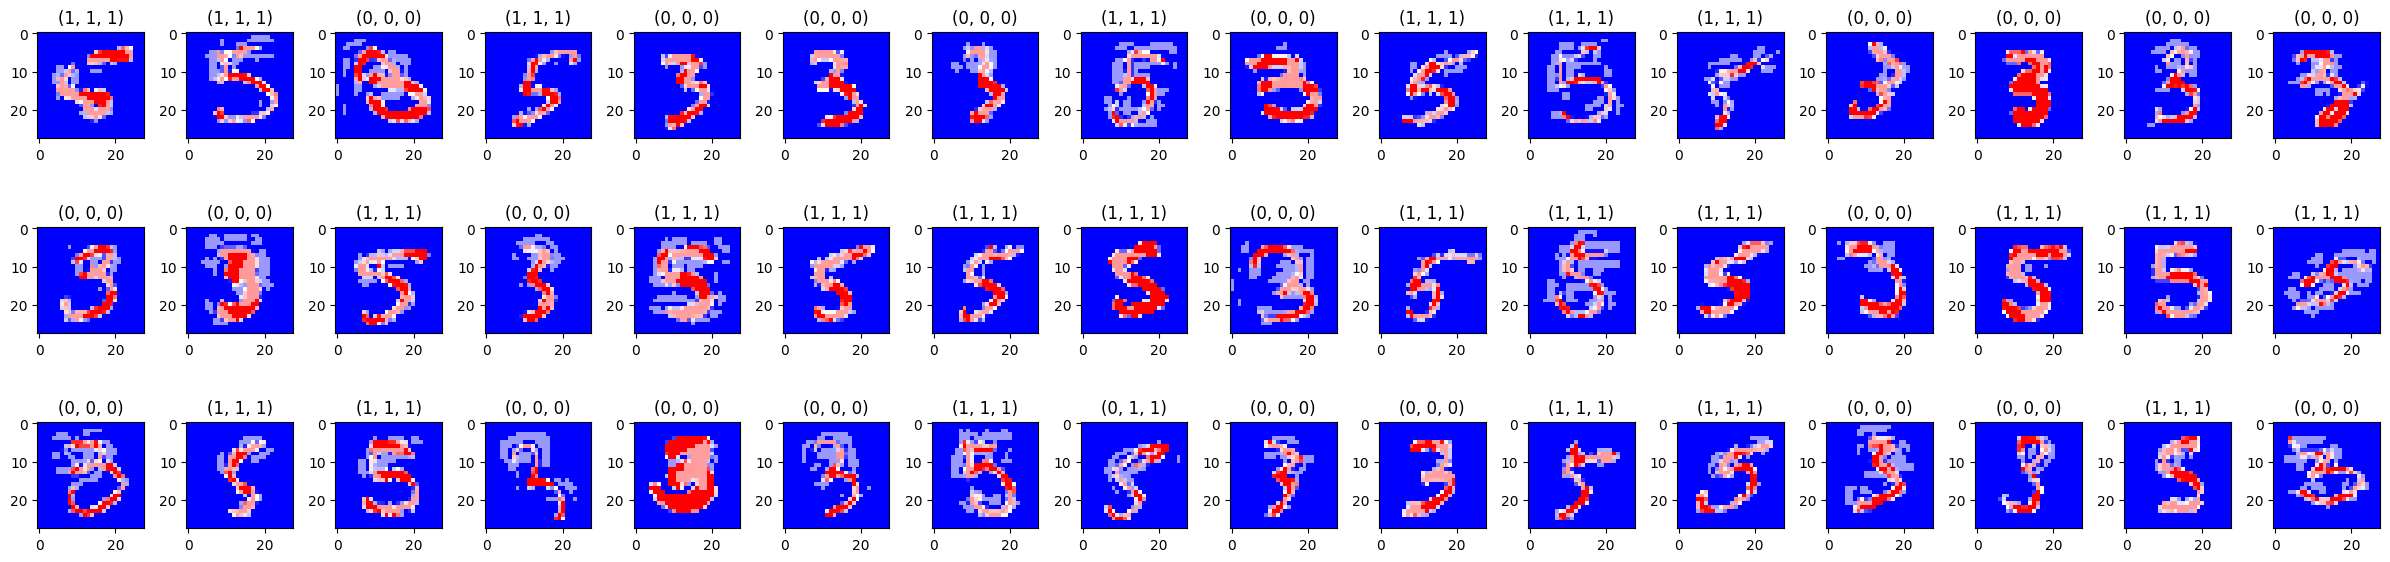

In [72]:
classifier = get_classifier(model)
attack = FastGradientMethod(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

### AutoPGD

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 95.83333333333334%


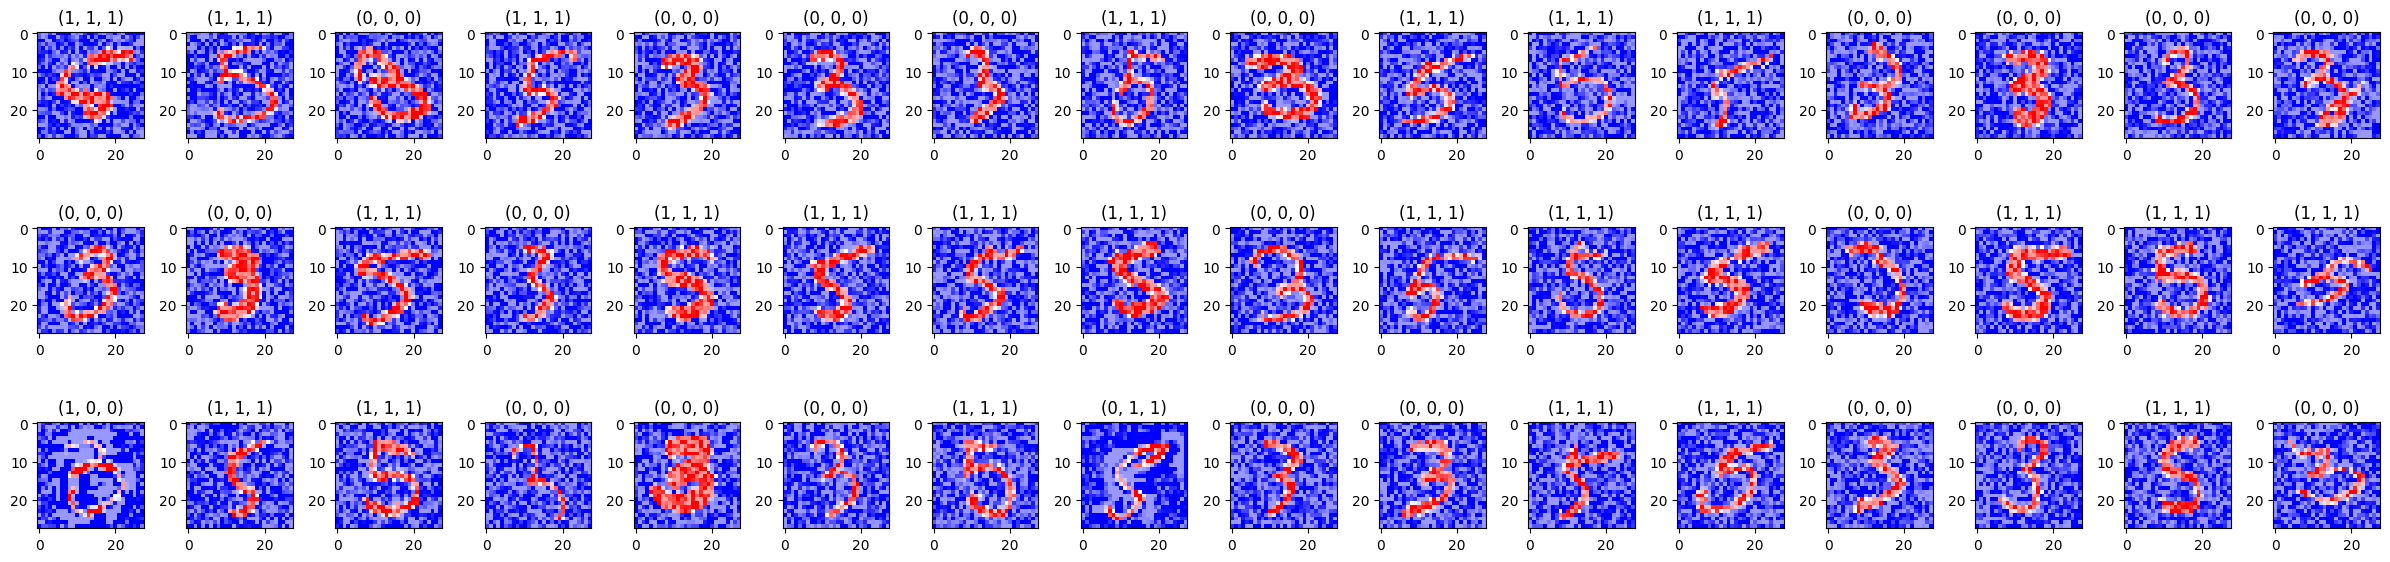

In [73]:
classifier = get_classifier(model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

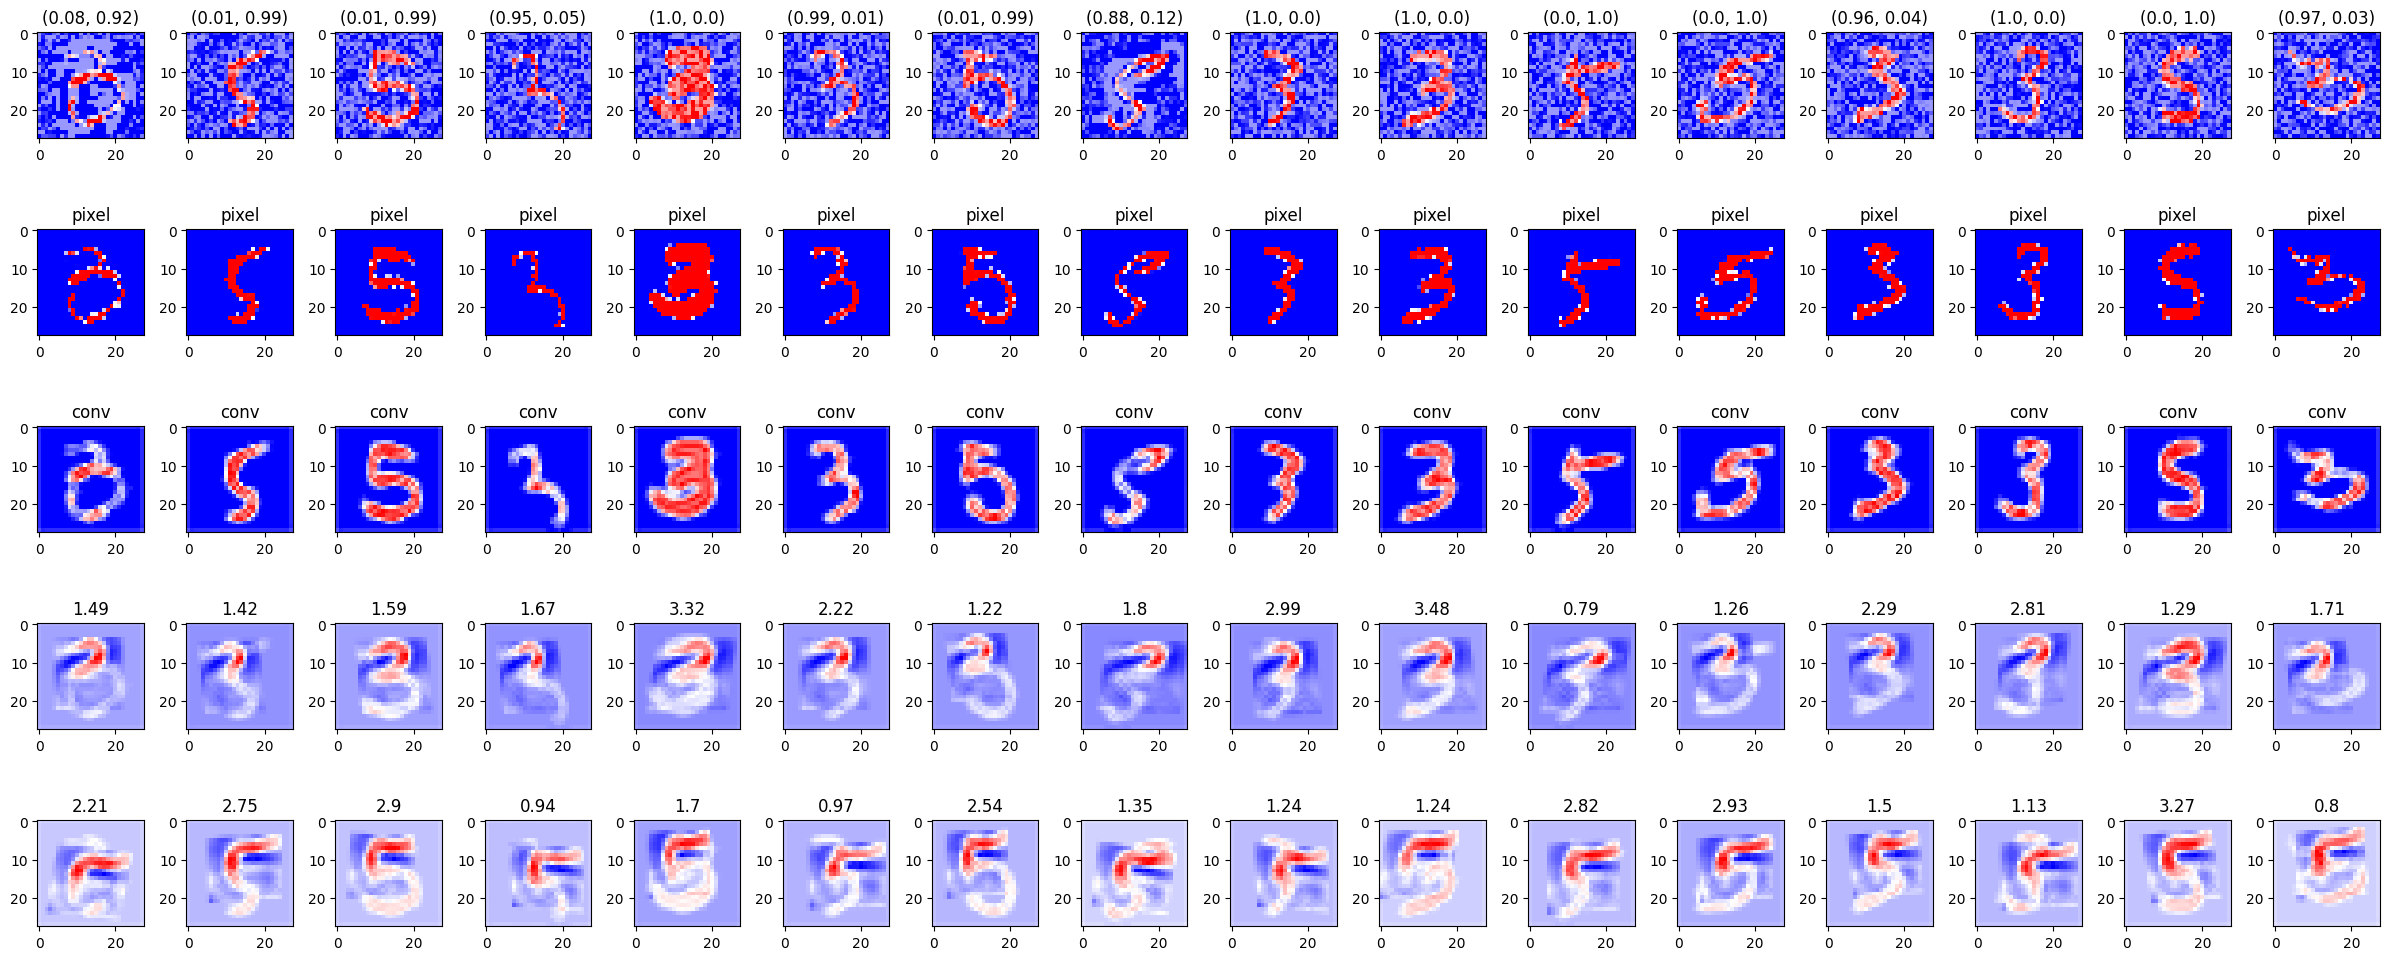

In [74]:
xx = x_test_adv[32:48]
layer_vis, labels = visualize_processing_steps(bb, xx)

hh.plot_example(layer_vis, y=labels, n_row=5)

### AutoPGD DLR loss

In [75]:
class DLRAdapter(nn.Module):
    # DLR loss requires at least 3 labels so we add a dummy label to the output
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def forward(self, x):
        x = self.model(x)
        x = torch.cat([x, -100*torch.ones_like(x)[:, :1]], dim=1)
        return x
    
    def configure_optimizers(self):
        return self.model.configure_optimizers()

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 93.75%


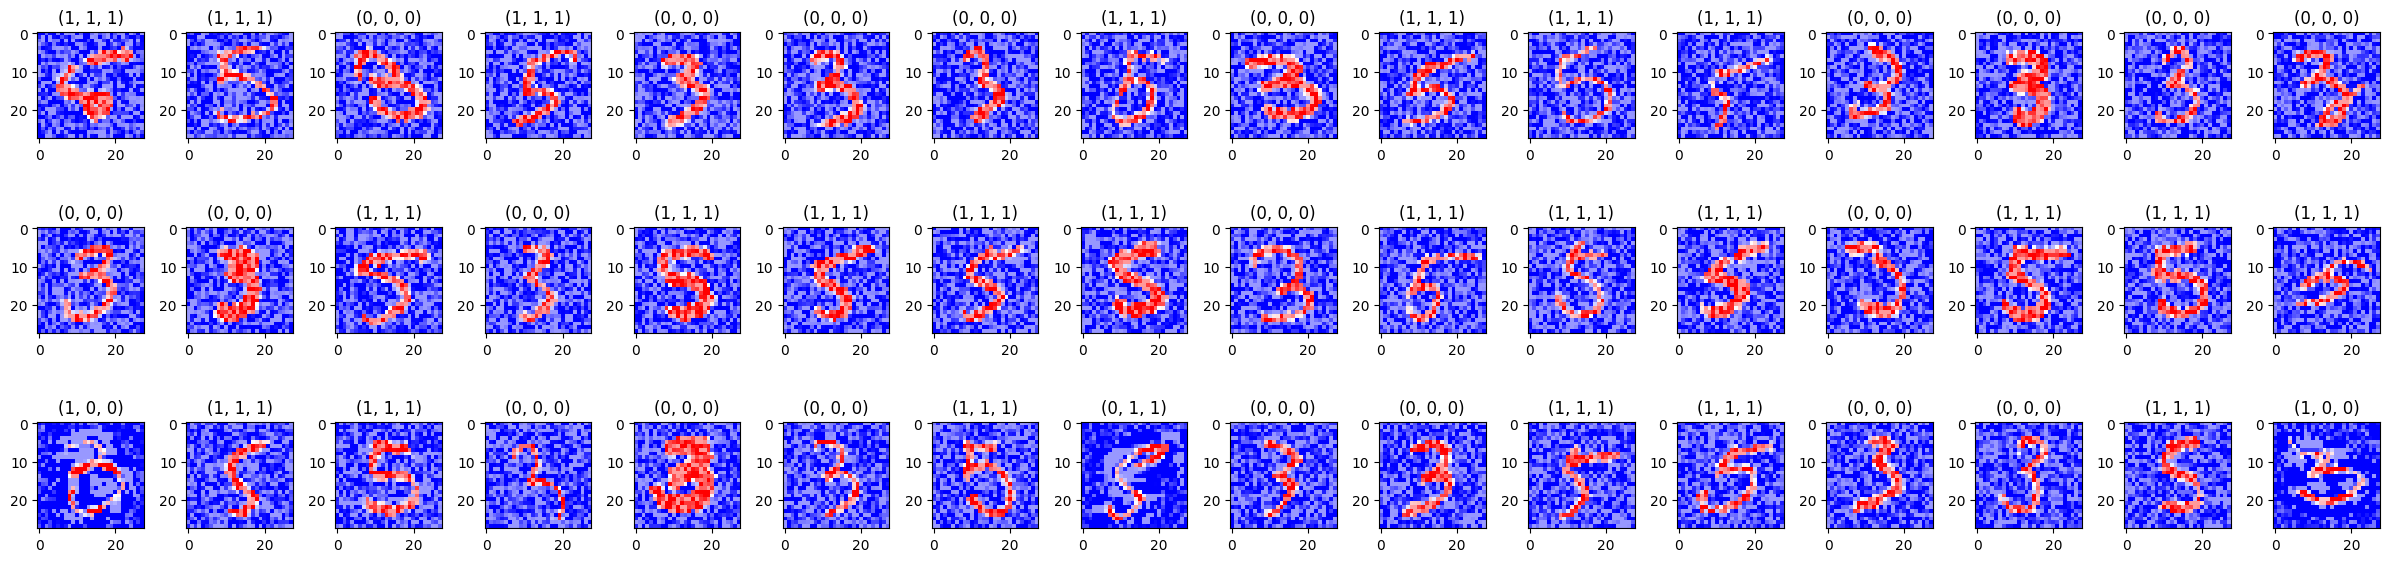

In [76]:
adapted_model = DLRAdapter(model)

classifier = get_classifier(adapted_model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE, loss_type="difference_logits_ratio")
x_test_adv, y_tests = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv, y_tests)

## Slow attacks on tiny subset

### Square attack

SquareAttack - restarts:   0%|          | 0/5 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 81.25%


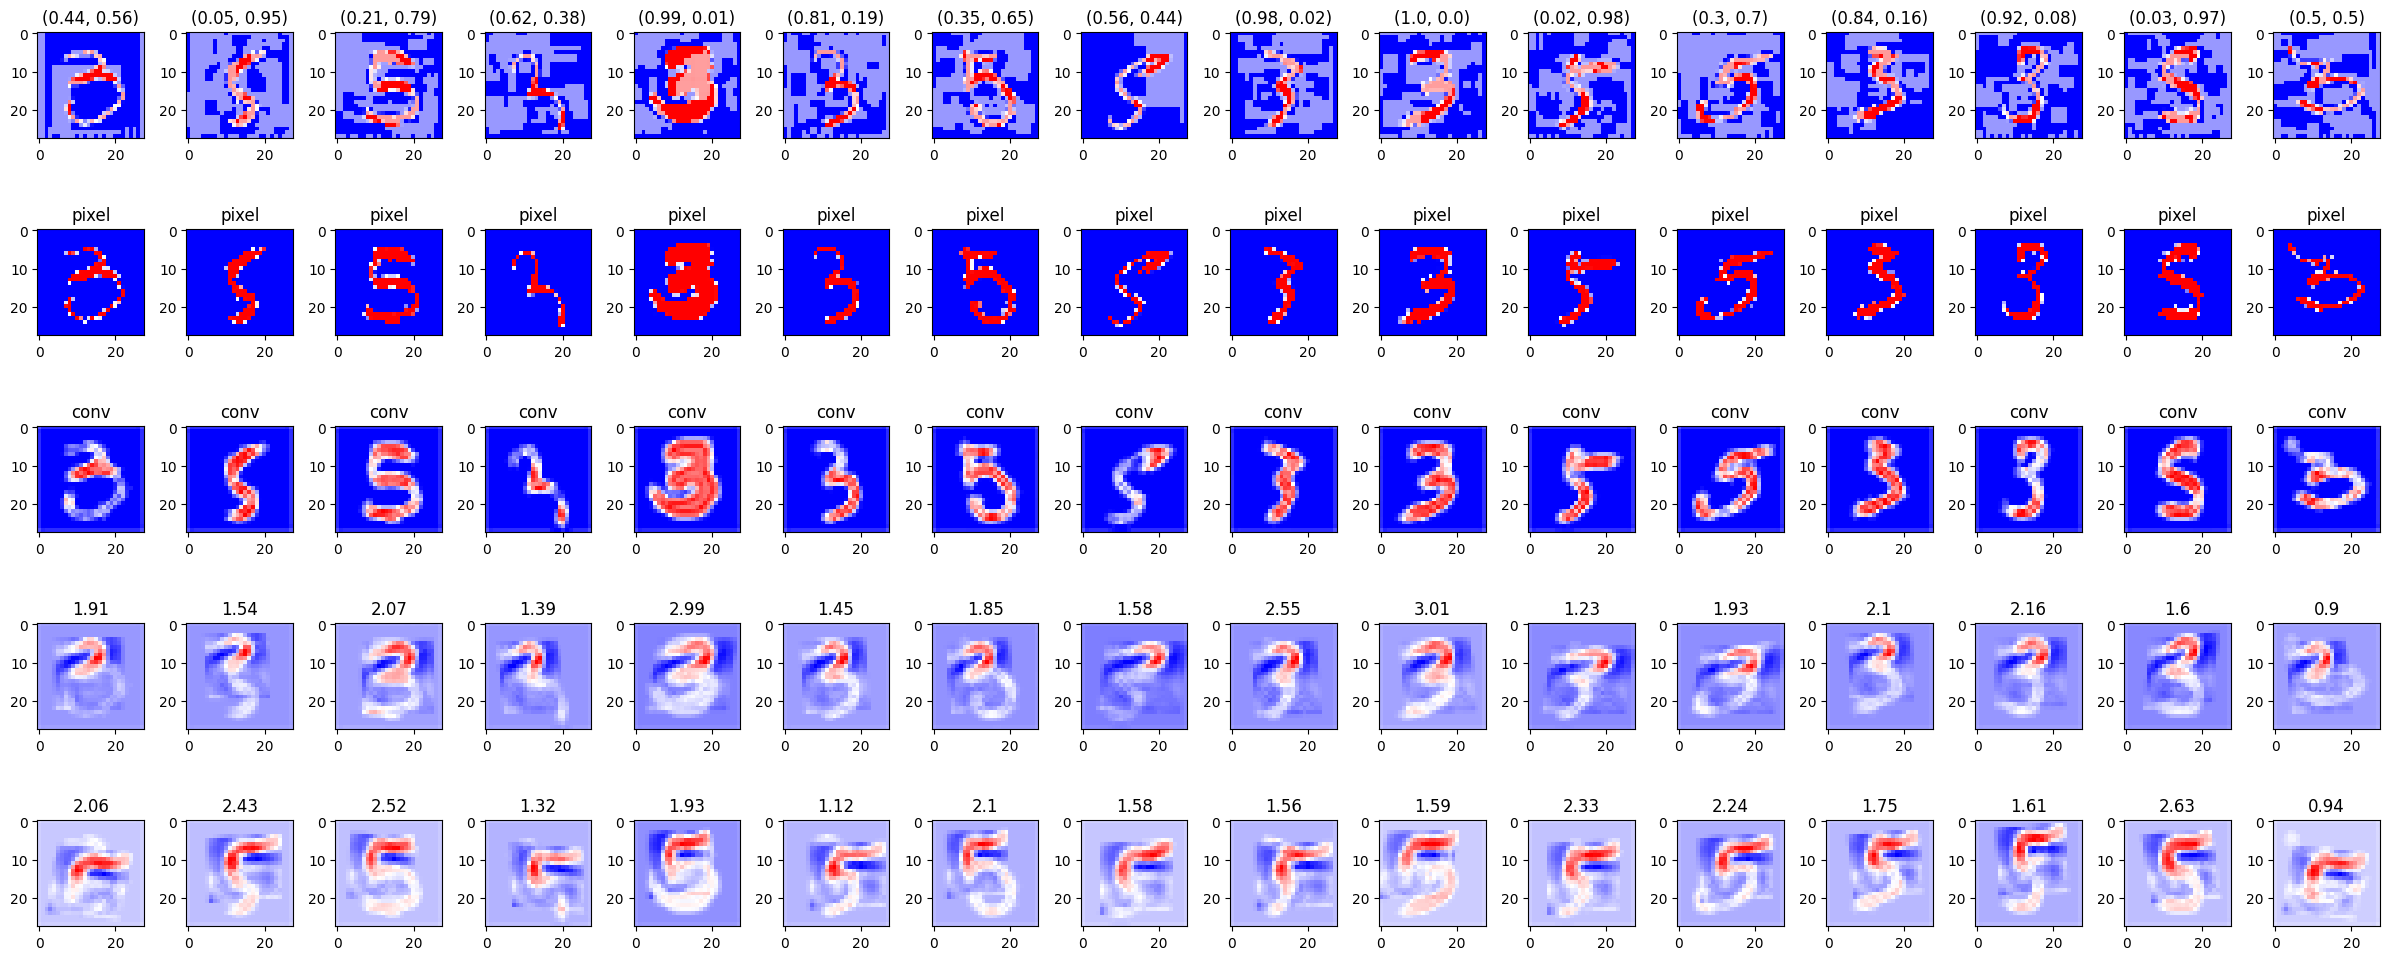

In [77]:
classifier = get_classifier(model)
attack = SquareAttack(estimator=classifier, norm=np.inf, max_iter=5000, eps=EPS, p_init=0.8, nb_restarts=5)
x_test_adv_square, y_tests_square = perform_attack(classifier, attack, x_test_small, y_test_small)

xx = x_test_adv_square
layer_vis, labels = visualize_processing_steps(bb, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

### Boundary attack

Boundary attack:   0%|          | 0/16 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 0.0%


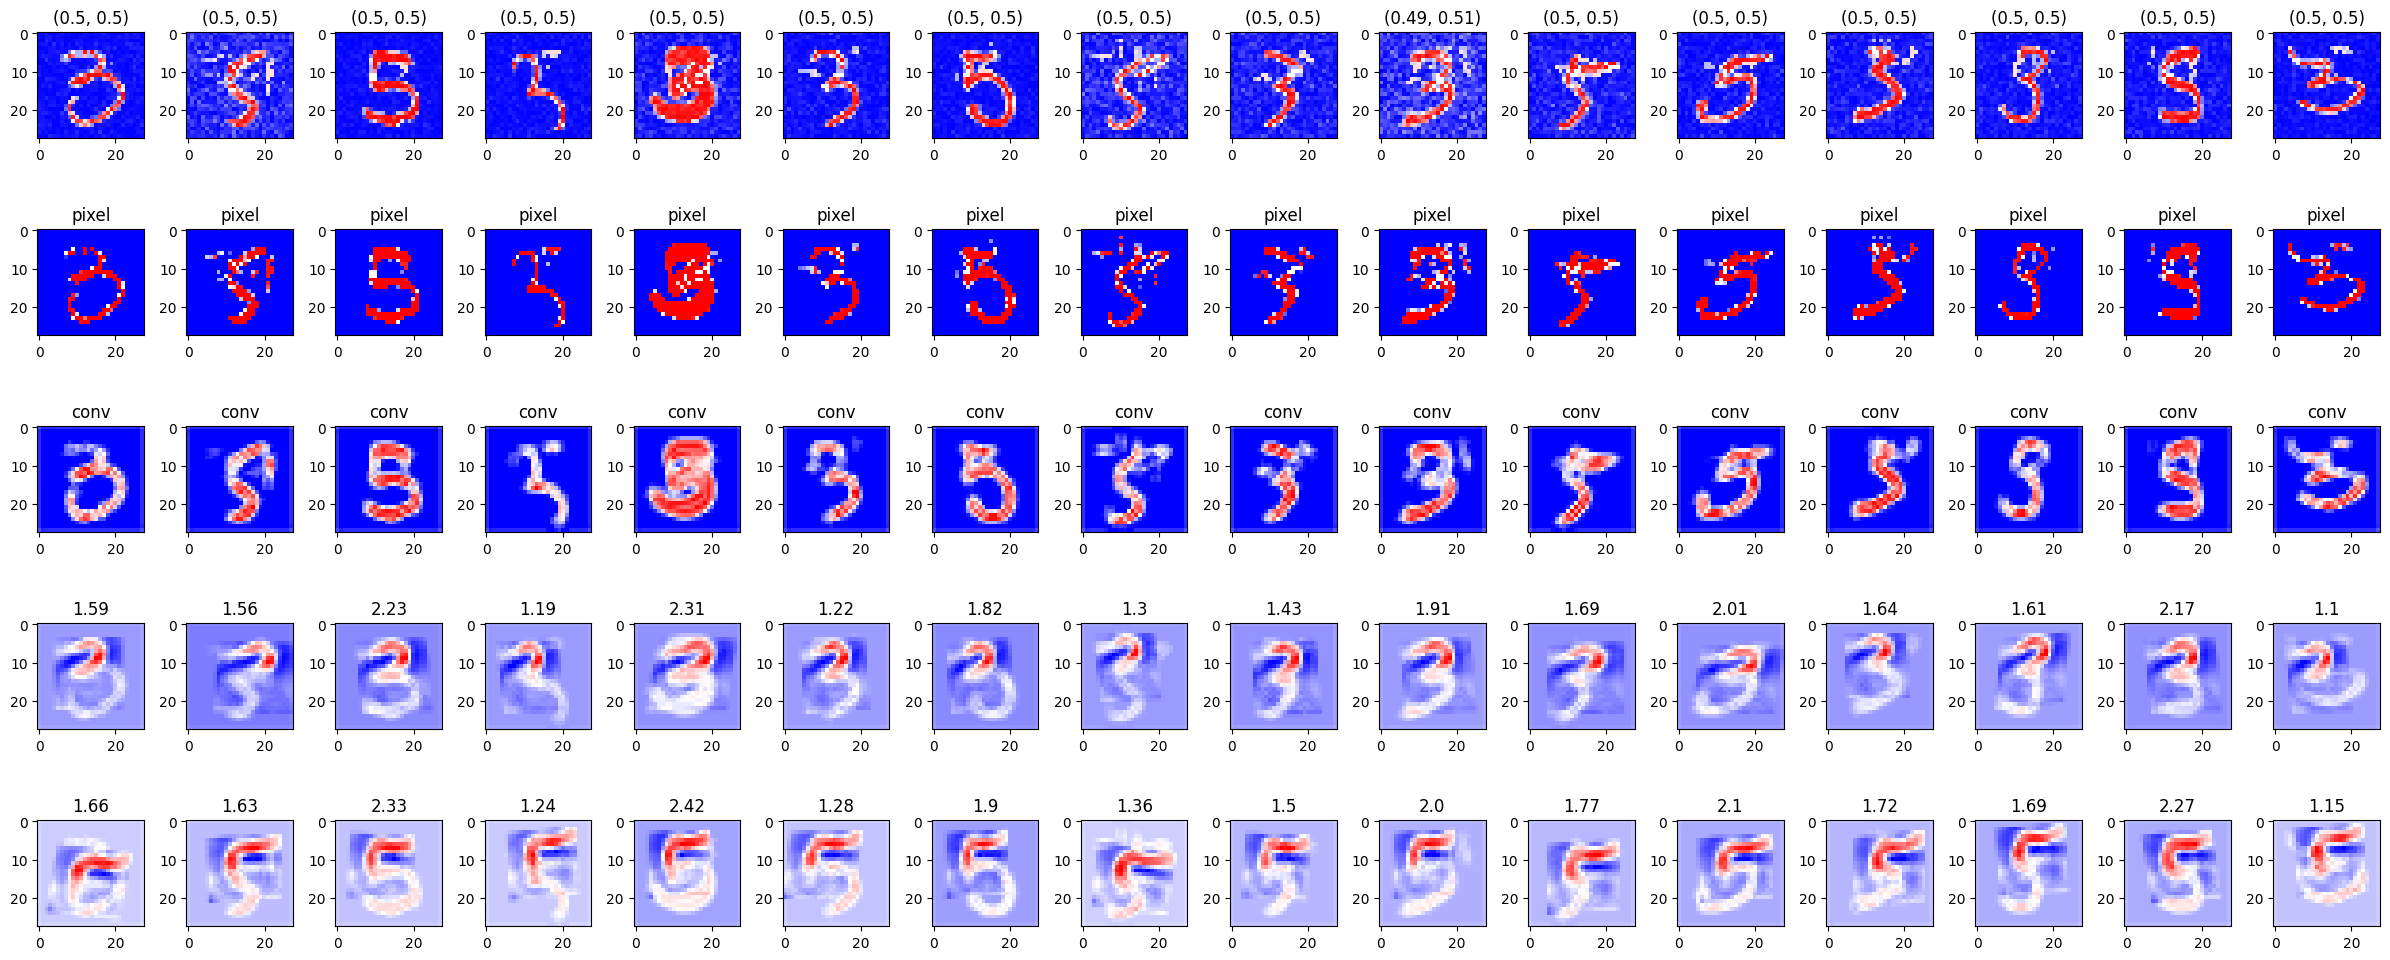

In [78]:
classifier = get_classifier(model)
attack = BoundaryAttack(estimator=classifier, targeted=False, min_epsilon=0.0, max_iter=1000)
x_test_adv_boundary_small, y_tests_boundary_small = perform_attack(classifier, attack, x_test_small, y_test_small)

xx = x_test_adv_boundary_small
layer_vis, labels = visualize_processing_steps(bb, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

## Attacks on full test

### AutoAttack

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

SquareAttack - iterations:   0%|          | 0/5000 [00:00<?, ?it/s]

Accuracy on clean test examples: 99.36908517350159%
Accuracy on adversarial test examples: 89.43217665615141%


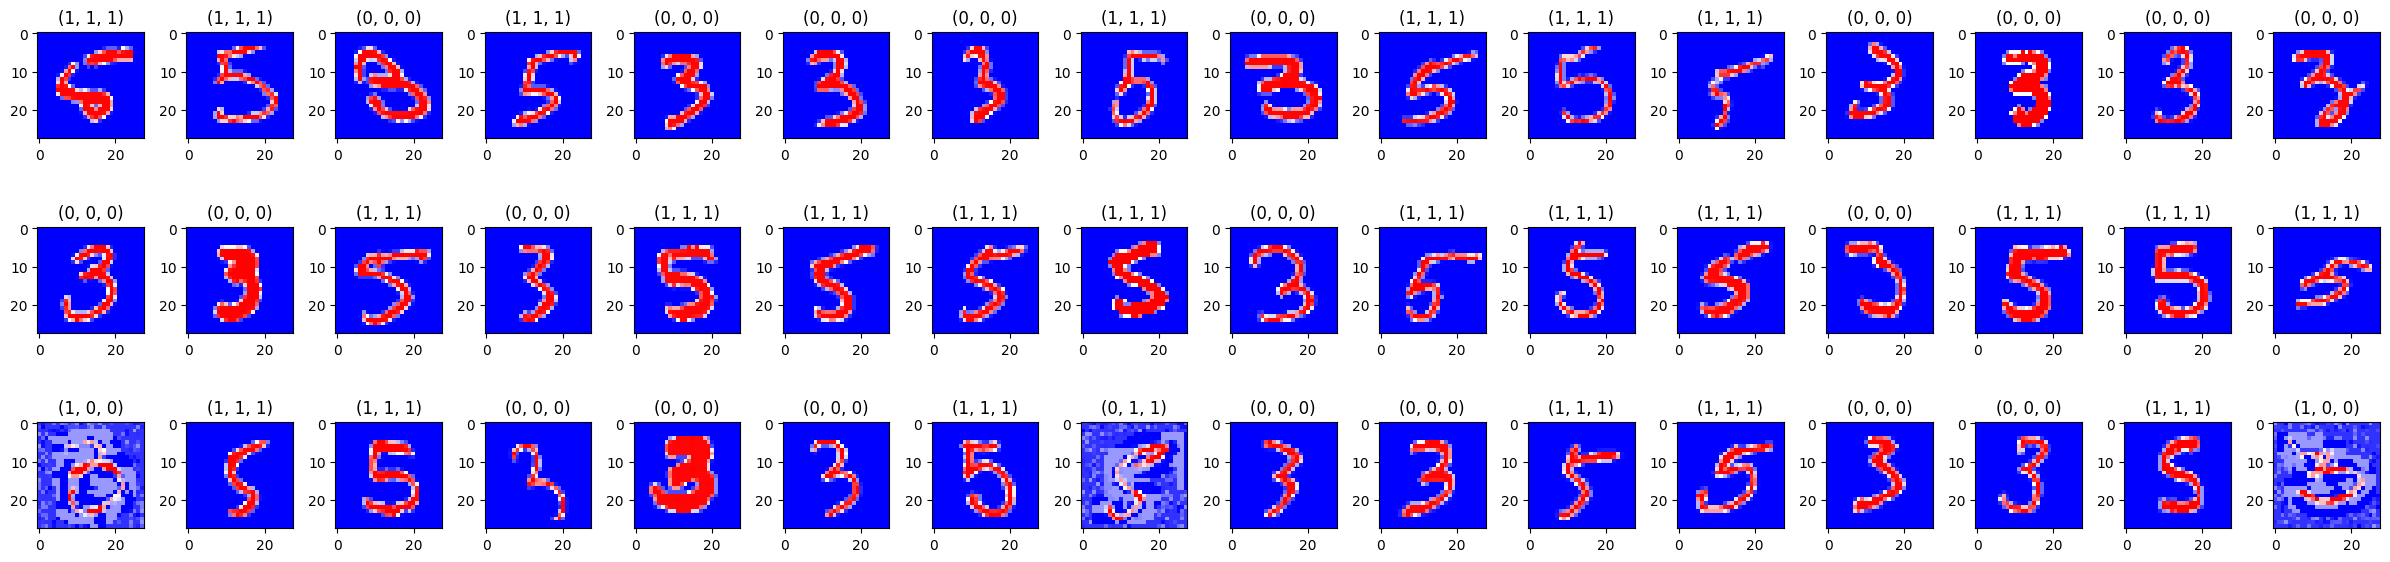

In [211]:
adapted_model = DLRAdapter(model)

classifier = get_classifier(adapted_model)
attack = AutoAttack(estimator=classifier, eps=EPS, eps_step=STEP_SIZE, batch_size=2000)
x_test_adv_all, y_tests_all = perform_attack(classifier, attack, x_test_all, y_test_all)

hh.plot_example(x_test_adv_all, y_tests_all)

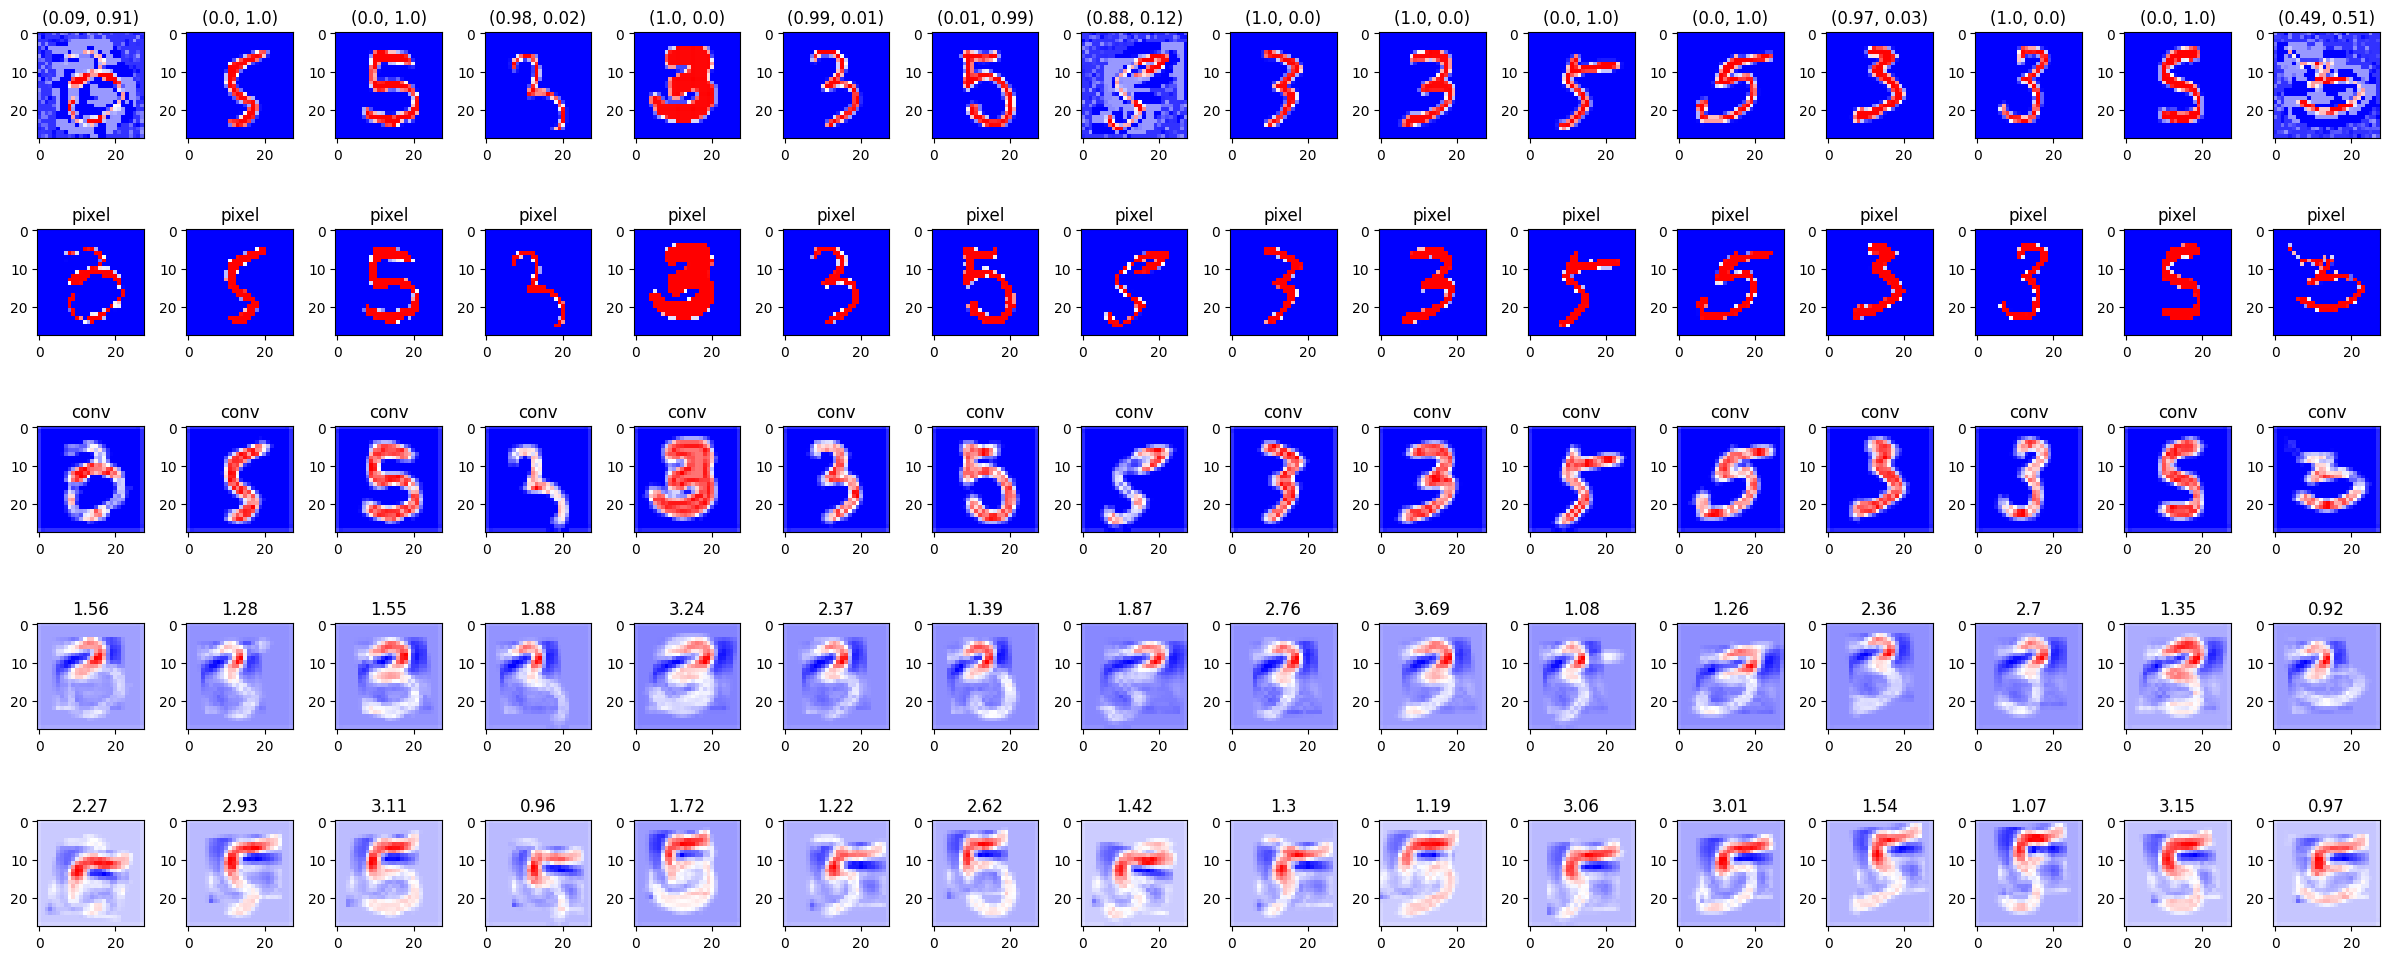

In [56]:
xx = x_test_adv_all[32:48]
layer_vis, labels = visualize_processing_steps(bb, xx)
hh.plot_example(layer_vis, y=labels, n_row=5)

### AutoPGD on full test - sanity check

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

AutoPGD - batch:   0%|          | 0/60 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

AutoPGD - iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on clean test examples: 99.36908517350159%
Accuracy on adversarial test examples: 89.95793901156676%


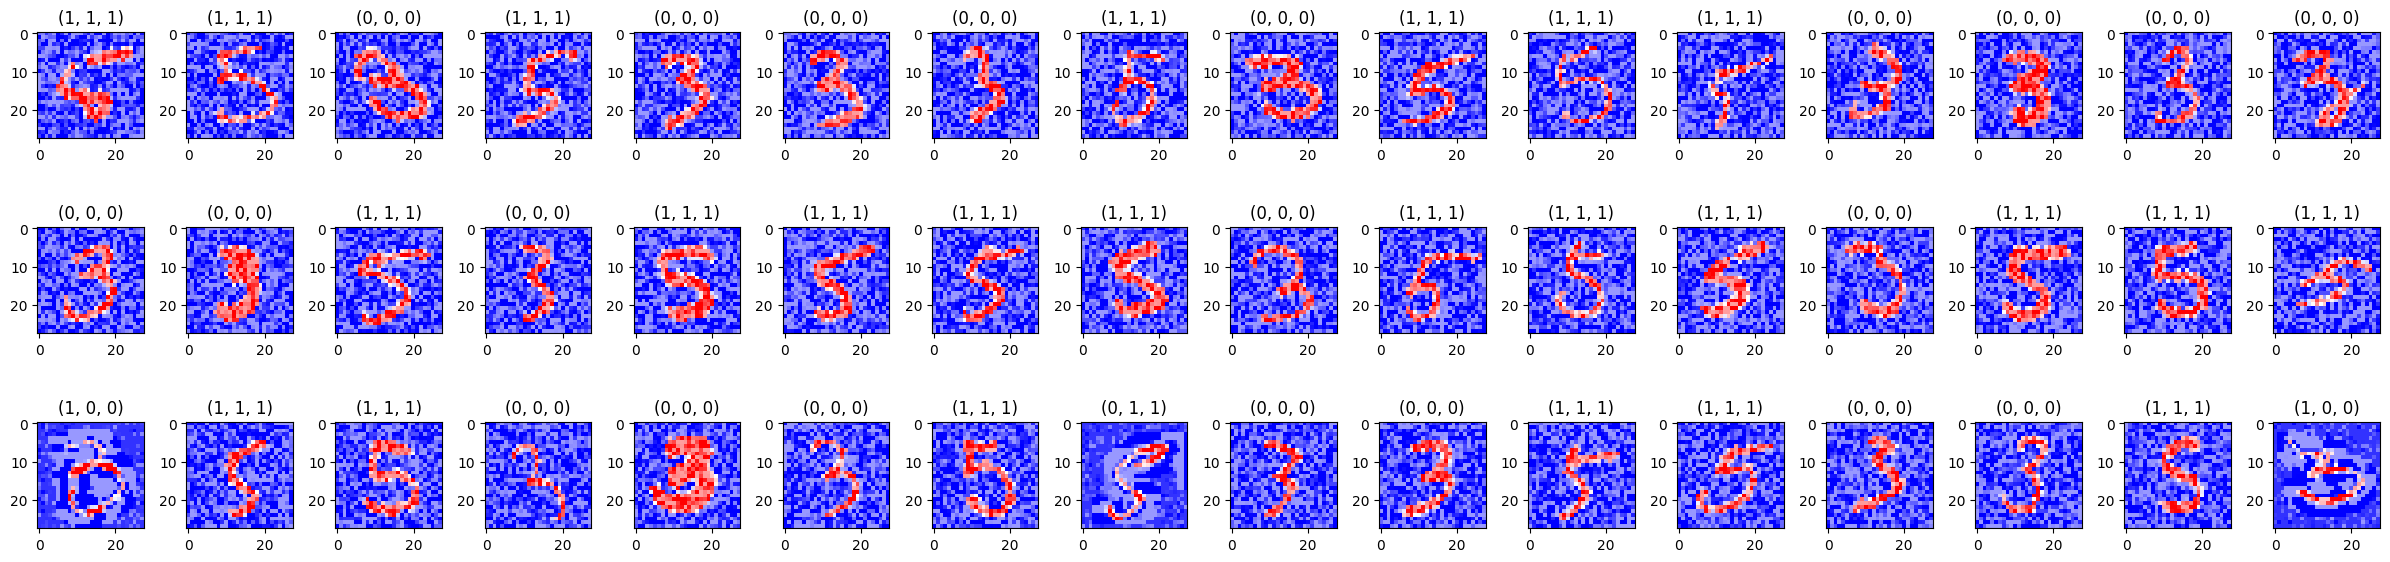

In [58]:
classifier = get_classifier(model)
attack = AutoProjectedGradientDescent(estimator=classifier, eps=EPS, eps_step=STEP_SIZE)
x_test_adv_pgd_all, y_tests_pgd_all = perform_attack(classifier, attack, x_test_all, y_test_all)

hh.plot_example(x_test_adv_pgd_all, y_tests_pgd_all)

### Boundary attack - more examples

Boundary attack:   0%|          | 0/48 [00:00<?, ?it/s]

Accuracy on clean test examples: 100.0%
Accuracy on adversarial test examples: 0.0%


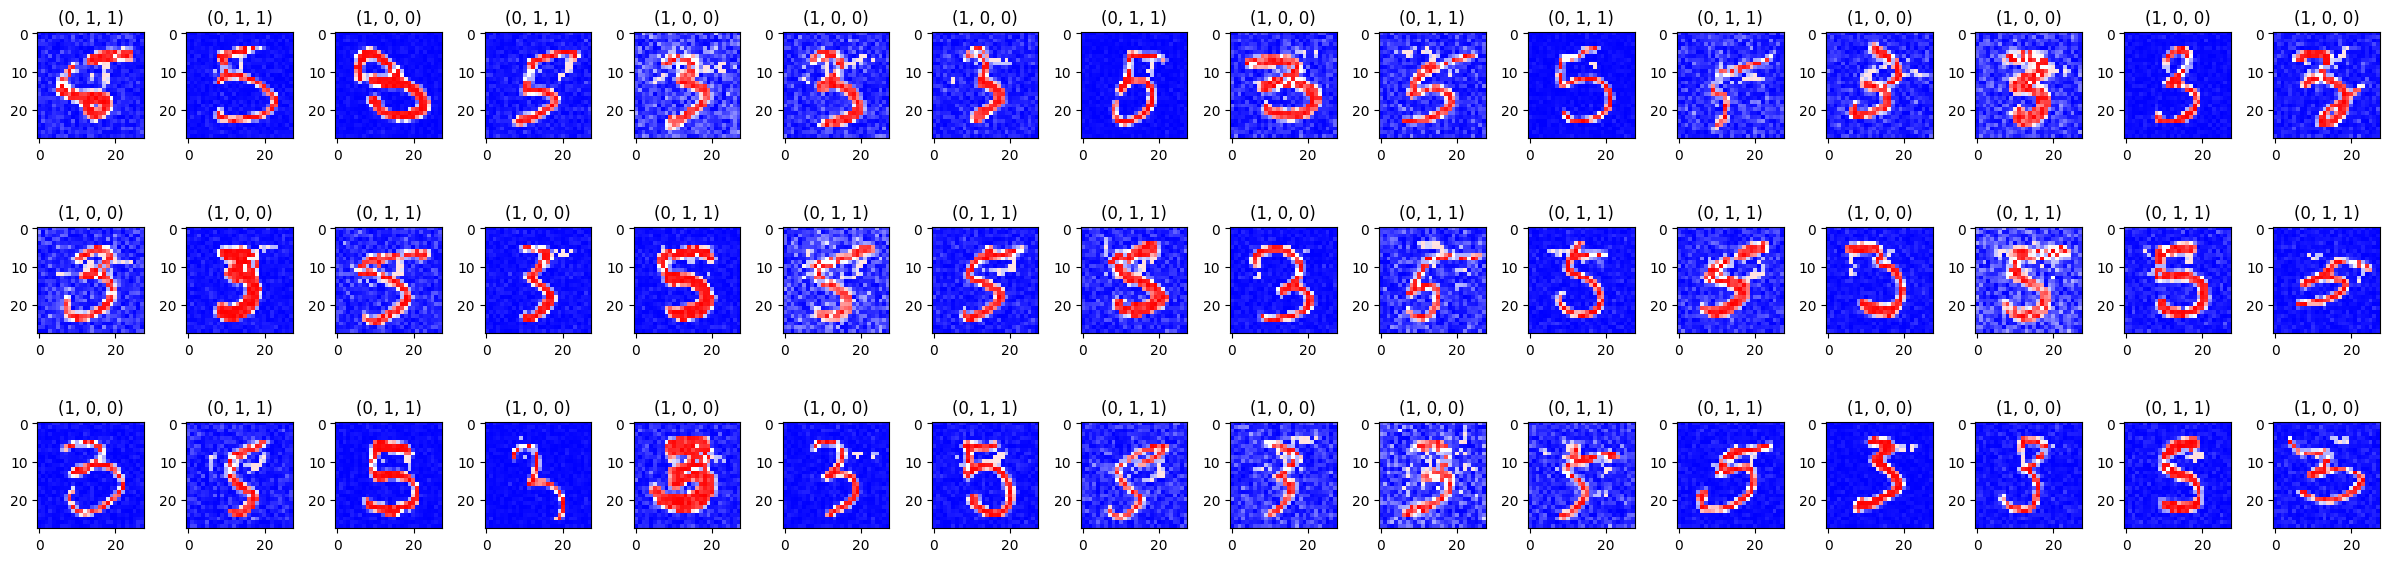

In [62]:
classifier = get_classifier(model)
attack = BoundaryAttack(estimator=classifier, targeted=False, min_epsilon=0.0, max_iter=1000)
x_test_adv_boundary, y_tests_boundary = perform_attack(classifier, attack, x_test, y_test)

hh.plot_example(x_test_adv_boundary, y=y_tests_boundary, n_row=3)